In [1]:
# Install Dependencies
!pip install nibabel matplotlib tensorflow opencv-python medpy scikit-image -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 48.4 MB/s eta 0:00:00


In [2]:
# Import necessary libraries for data handling, model building, visualization, and model prediction
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from medpy.metric.binary import hd95, dc
import zipfile
from io import BytesIO
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import gc
from matplotlib.colors import ListedColormap
import matplotlib
from google.colab import drive
import pandas as pd
import random

# Mount Google Drive to access data files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Define global constants for data paths, model parameters, and labels
# These constants configure file paths, training parameters, image dimensions, and class labels
ZIP_PATH = "/content/drive/MyDrive/data.zip"  # Path to ZIP file containing H5 image data
NIFTI_ZIP_PATH = "/content/drive/MyDrive/369Seg_Masks_nii.zip"  # Path to ZIP file containing NIfTI segmentation masks
H5_FILES_PREFIX = 'data/volume_'  # Prefix for H5 files in ZIP
H5_FILES_SUFFIX = '.h5'  # Suffix for H5 files
MAX_SAMPLES = 369  # Maximum number of patients to process
EPOCHS = 50  # Number of training epochs
IMG_HEIGHT, IMG_WIDTH = 240, 240  # Image dimensions for resizing
VOLUME_SLICES = 110  # Number of slices per patient volume
VOLUME_START_AT = 22  # Starting slice index for processing
MODALITIES = ["FLAIR", "T2", "T1ce", "T1"]  # MRI modalities available
MODALITY_INDICES = {"T1": 3, "T1ce": 2, "T2": 1, "FLAIR": 0}  # Indices for modalities in H5 files
CLASS_LABELS = {0: "Background", 1: "Non-enhancing Tumor", 2: "Edema", 3: "Enhancing Tumor"}  # Segmentation class labels
METRIC_LABELS = {"WT": "Whole Tumor", "ET": "Enhancing Tumor", "TC": "Tumor Core"}  # Evaluation metric labels
SAVE_PATH_MODEL = "/content/drive/MyDrive/Model_Save/optimized_dr_unet_model3.keras"  # Path to save trained model
BATCH_SIZE = 4  # Batch size for training
PATIENCE = 5  # Patience for early stopping

# Enable mixed precision to optimize performance and reduce memory usage
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


# Verify existence of ZIP files to prevent file access errors
if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(f"ZIP file not found at {ZIP_PATH}")
if not os.path.exists(NIFTI_ZIP_PATH):
    raise FileNotFoundError(f"NIfTI ZIP file not found at {NIFTI_ZIP_PATH}")

In [4]:
# Define Dice coefficient metric for evaluating segmentation overlap
def dice_coef(y_true, y_pred, smooth=1.0):
    """
    Calculate Dice coefficient for model evaluation.

    Args:
        y_true: Ground truth tensor.
        y_pred: Predicted tensor.
        smooth: Smoothing factor to avoid division by zero.

    Returns:
        float: Dice coefficient value.
    """
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# ***1.*** ***DR-Unet Model Building***

In [5]:
# Define soft Dice loss for training the model
def soft_dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Compute soft Dice loss for model optimization.

    Args:
        y_true: Ground truth tensor.
        y_pred: Predicted tensor.
        smooth: Smoothing factor to avoid division by zero.

    Returns:
        float: Soft Dice loss value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])  # Sum over height, width, channels
    true_sum = tf.reduce_sum(y_true, axis=[1, 2, 3])
    pred_sum = tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (true_sum + pred_sum + smooth)
    return 1 - tf.reduce_mean(dice)  # Loss is 1 minus mean Dice score

In [6]:
# Define Squeeze-and-Excitation block to enhance feature representation
def se_block(input_tensor, ratio=8):
    """
    Implement Squeeze-and-Excitation block to recalibrate channel-wise features.

    Args:
        input_tensor: Input tensor.
        ratio: Reduction ratio for the dense layers.

    Returns:
        tensor: Output tensor with recalibrated features.
    """
    filters = tf.keras.backend.int_shape(input_tensor)[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.Multiply()([input_tensor, se])

In [7]:
# Define residual block for improved gradient flow
def residual_block(x, filters, dropout_rate=0.2):
    """
    Implement residual block with shortcut connection.

    Args:
        x: Input tensor.
        filters: Number of filters for convolutions.
        dropout_rate: Dropout rate for regularization.

    Returns:
        tensor: Output tensor after residual connection.
    """
    input_filters = tf.keras.backend.int_shape(x)[-1]
    shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x) if input_filters != filters else x
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    return layers.Add()([shortcut, x])

In [8]:
# Define bottleneck block with SE for efficient feature extraction
def bottleneck_block(x, filters, stride=1, dropout_rate=0.2):
    """
    Implement bottleneck block with Squeeze-and-Excitation.

    Args:
        x: Input tensor.
        filters: Number of filters for convolutions.
        stride: Stride for downsampling.
        dropout_rate: Dropout rate for regularization.

    Returns:
        tensor: Output tensor after bottleneck and SE.
    """
    input_filters = tf.keras.backend.int_shape(x)[-1]
    shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters // 4, (1, 1), strides=stride, padding='same')(x)
    x = layers.Conv2D(filters // 4, (3, 3), padding='same')(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = se_block(x)
    return layers.Add()([x, shortcut])

In [9]:
# Define the DR-Unet architecture
def optimized_dr_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 2), dropout_rate=0.2):
    """
    Build the DR-Unet model with encoder-decoder structure and skip connections.

    Args:
        input_shape: Shape of input images (height, width, channels).
        dropout_rate: Dropout rate for regularization.

    Returns:
        Model: Compiled Keras model.
    """
    inputs = layers.Input(shape=input_shape)
    # Encoder path
    e1 = bottleneck_block(inputs, 32, dropout_rate=dropout_rate)
    e2 = bottleneck_block(e1, 64, stride=2, dropout_rate=dropout_rate)
    e3 = bottleneck_block(e2, 128, stride=2, dropout_rate=dropout_rate)
    e4 = bottleneck_block(e3, 256, stride=2, dropout_rate=dropout_rate)
    b = bottleneck_block(e4, 256, dropout_rate=dropout_rate)
    # Decoder path with skip connections
    d4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    d4 = layers.Concatenate()([d4, e3])
    d4 = residual_block(d4, 128, dropout_rate=dropout_rate)
    d3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d4)
    d3 = layers.Concatenate()([d3, e2])
    d3 = residual_block(d3, 64, dropout_rate=dropout_rate)
    d2 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(d3)
    d2 = layers.Concatenate()([d2, e1])
    d2 = residual_block(d2, 32, dropout_rate=dropout_rate)
    outputs = layers.Conv2D(4, (1, 1), activation='softmax', dtype='float32')(d2)
    return models.Model(inputs, outputs)

# ***2. Data Preparation***

In [10]:
# Preload data into memory for faster access during training
def preload_data(patient_ids, zip_path, nifti_zip_path, dim=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Load and preprocess image and mask data for all patients into memory.

    Args:
        patient_ids: List of patient IDs.
        zip_path: Path to ZIP file with H5 image data.
        nifti_zip_path: Path to ZIP file with NIfTI segmentation masks.
        dim: Target dimensions for resizing images and masks.

    Returns:
        dict: Dictionary with preloaded images and masks for each patient.
    """
    data = {}
    for pid in patient_ids:
        data[pid] = {'images': [], 'masks': []}
        # Load segmentation mask from NIfTI file
        with zipfile.ZipFile(nifti_zip_path, 'r') as nifti_zip_ref:
            nifti_file = f"369Seg_Masks_nii/BraTS20_Training_{int(pid):03d}_seg.nii"
            with nifti_zip_ref.open(nifti_file) as f:
                mask = nib.Nifti1Image.from_bytes(f.read()).get_fdata().astype(np.uint8)

        # Identify slices with tumor presence
        valid_slices = []
        for j in range(VOLUME_SLICES):
            slice_idx = j + VOLUME_START_AT
            if slice_idx >= mask.shape[2]:
                continue
            mask_slice = mask[:, :, slice_idx]
            if np.any(np.isin(mask_slice, [1, 2, 3, 4])):  # Check for tumor labels
                valid_slices.append(j)

        # Preallocate arrays for images and masks
        num_slices = len(valid_slices)
        images = np.zeros((num_slices, dim[0], dim[1], 2), dtype=np.float16)
        masks = np.zeros((num_slices, dim[0], dim[1], 4), dtype=np.float16)

        # Load and preprocess images from H5 files
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for i, j in enumerate(valid_slices):
                slice_idx = j + VOLUME_START_AT
                h5_file = f"{H5_FILES_PREFIX}{pid}_slice_{slice_idx}{H5_FILES_SUFFIX}"
                if h5_file in zip_ref.namelist():
                    with zip_ref.open(h5_file) as f:
                        with h5py.File(BytesIO(f.read()), 'r') as hf:
                            img = hf['image'][:]
                    img_slice = img[:, :, [MODALITY_INDICES["FLAIR"], MODALITY_INDICES["T1ce"]]]
                    img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + 1e-8)
                    img_slice = cv2.resize(img_slice, dim)
                    mask_slice = mask[:, :, slice_idx]
                    mask_slice[mask_slice == 4] = 3  # Map label 4 to 3
                    onehot_mask = to_categorical(mask_slice, num_classes=4)
                    onehot_mask = cv2.resize(onehot_mask, dim)
                    images[i] = img_slice
                    masks[i] = onehot_mask

        data[pid]['images'] = images
        data[pid]['masks'] = masks

    return data

In [11]:
# Create tf.data.Dataset for efficient data loading during training
def create_dataset(patient_ids, preloaded_data, batch_size, shuffle=True):
    """
    Create a tf.data.Dataset from preloaded data for training or evaluation.

    Args:
        patient_ids: List of patient IDs.
        preloaded_data: Dictionary with preloaded images and masks.
        batch_size: Number of samples per batch.
        shuffle: Whether to shuffle the dataset.

    Returns:
        tf.data.Dataset: Dataset for model training or evaluation.
    """
    def gen():
        for pid in patient_ids:
            images = preloaded_data[pid]['images']
            masks = preloaded_data[pid]['masks']
            indices = np.arange(len(images))
            if shuffle:
                np.random.shuffle(indices)
            for idx in indices:
                yield images[idx], masks[idx]

    dataset = tf.data.Dataset.from_generator(
        generator=gen,
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 2), dtype=tf.float16),
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 4), dtype=tf.float16)
        )
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load patient IDs and split into train, validation, and test sets
# Extract patient IDs from ZIP file and perform a stratified split into training, validation, and test sets
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    filenames = [f for f in zip_ref.namelist() if f.startswith(H5_FILES_PREFIX) and f.endswith(H5_FILES_SUFFIX)]
    patient_ids = sorted(list(set(f.split('/')[-1].split('_')[1] for f in filenames if 'slice' in f)))[:MAX_SAMPLES]

train_ids, temp_ids = train_test_split(patient_ids, train_size=0.7, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.333, random_state=42)

# Print dataset split statistics
print(f"Patient Split: {len(train_ids)} train ({len(train_ids)/len(patient_ids):.2%}), "
      f"{len(val_ids)} validation ({len(val_ids)/len(patient_ids):.2%}), "
      f"{len(test_ids)} test ({len(test_ids)/len(patient_ids):.2%})")
print(f"Train IDs: {train_ids}")
print(f"Validation IDs: {val_ids}")
print(f"Test IDs: {test_ids}")

# Preload data for all patients
print("Preloading data...")
preloaded_data = preload_data(patient_ids, ZIP_PATH, NIFTI_ZIP_PATH)
train_dataset = create_dataset(train_ids, preloaded_data, BATCH_SIZE, shuffle=True)
val_dataset = create_dataset(val_ids, preloaded_data, BATCH_SIZE, shuffle=False)
test_dataset = create_dataset(test_ids, preloaded_data, BATCH_SIZE, shuffle=False)

Patient Split: 258 train (69.92%), 74 validation (20.05%), 37 test (10.03%)
Train IDs: ['254', '276', '116', '85', '170', '25', '115', '278', '193', '356', '205', '81', '127', '131', '241', '264', '250', '39', '224', '69', '257', '152', '2', '232', '104', '344', '327', '108', '313', '192', '172', '263', '338', '30', '366', '83', '52', '231', '282', '182', '161', '82', '186', '228', '352', '187', '58', '160', '12', '132', '229', '209', '16', '248', '84', '364', '255', '211', '230', '289', '177', '47', '262', '48', '259', '351', '94', '335', '360', '334', '215', '133', '109', '32', '266', '40', '20', '260', '319', '308', '204', '73', '87', '339', '68', '247', '300', '221', '238', '279', '277', '92', '100', '361', '202', '288', '29', '122', '207', '355', '340', '53', '213', '166', '369', '125', '174', '63', '196', '317', '56', '219', '265', '4', '139', '72', '158', '347', '176', '267', '162', '242', '11', '130', '124', '252', '227', '368', '321', '234', '304', '299', '217', '322', '145', 

# ***3. DR-Unet model Compiling and Training***

In [12]:
# Build and compile the optimized DR-Unet model with specified input shape and dropout rate
model = optimized_dr_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 2))
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=soft_dice_loss,
    metrics=['accuracy', dice_coef]
)

# Configure training callbacks to manage learning rate, model checkpointing, early stopping, and progress tracking
callbacks = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),  # Reduce learning rate on plateau
    callbacks.ModelCheckpoint(SAVE_PATH_MODEL, save_best_only=True, verbose=1),  # Save best model
    callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True),  # Stop early if no improvement
    TqdmCallback(verbose=1)  # Progress bar for training
]

# Train the model with the defined dataset and callbacks, with a fallback to batch size 1 if an error occurs
tf.keras.backend.clear_session()
try:
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=0
    )
except Exception as e:
    print(f"Training error: {str(e)}")
    # Fallback to batch size of 1 if training fails
    BATCH_SIZE = 1
    train_dataset = create_dataset(train_ids, preloaded_data, BATCH_SIZE, shuffle=True)
    val_dataset = create_dataset(val_ids, preloaded_data, BATCH_SIZE, shuffle=False)
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=0
    )

# Save the final model
# Save the trained model to the specified path
model.save(SAVE_PATH_MODEL)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.01810, saving model to /content/drive/MyDrive/Model_Save/optimized_dr_unet_model3.keras

Epoch 2: val_loss improved from 0.01810 to 0.01652, saving model to /content/drive/MyDrive/Model_Save/optimized_dr_unet_model3.keras

Epoch 3: val_loss did not improve from 0.01652

Epoch 4: val_loss improved from 0.01652 to 0.01258, saving model to /content/drive/MyDrive/Model_Save/optimized_dr_unet_model3.keras

Epoch 5: val_loss improved from 0.01258 to 0.01075, saving model to /content/drive/MyDrive/Model_Save/optimized_dr_unet_model3.keras

Epoch 6: val_loss did not improve from 0.01075

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 7: val_loss improved from 0.01075 to 0.01070, saving model to /content/drive/MyDrive/Model_Save/optimized_dr_unet_model3.keras

Epoch 8: val_loss improved from 0.01070 to 0.01010, saving model to /content/drive/MyDrive/Model_Save/optimized_dr_unet_model3.keras

Epoch 9: val_loss improved

# ***4. Evaluation***

In [13]:
# Evaluate model performance using DSC and HD95 metrics
def evaluate_model(dataset):
    """
    Evaluate model performance on a dataset using Dice Similarity Coefficient (DSC) and Hausdorff Distance (HD95).

    Args:
        dataset: tf.data.Dataset containing images and masks.

    Returns:
        dict: Metrics for Whole Tumor (WT), Enhancing Tumor (ET), and Tumor Core (TC).
    """
    results = {"WT": {"DSC": [], "HD95": []}, "ET": {"DSC": [], "HD95": []}, "TC": {"DSC": [], "HD95": []}}
    for X, y_true in dataset:
        y_pred = model.predict(X, verbose=0)
        y_pred = np.argmax(y_pred, axis=-1)
        y_true = np.argmax(y_true, axis=-1)
        for j in range(y_true.shape[0]):
            for metric in ["WT", "ET", "TC"]:
                if metric == "WT":
                    pred_bin = (y_pred[j] > 0).astype(np.uint8)
                    true_bin = (y_true[j] > 0).astype(np.uint8)
                elif metric == "ET":
                    pred_bin = (y_pred[j] == 3).astype(np.uint8)
                    true_bin = (y_true[j] == 3).astype(np.uint8)
                elif metric == "TC":
                    pred_bin = np.isin(y_pred[j], [1, 3]).astype(np.uint8)
                    true_bin = np.isin(y_true[j], [1, 3]).astype(np.uint8)
                if np.sum(true_bin) > 0:
                    results[metric]["DSC"].append(dc(pred_bin, true_bin))
                    try:
                        results[metric]["HD95"].append(hd95(pred_bin, true_bin))
                    except:
                        results[metric]["HD95"].append(np.nan)
    return {
        "WT": {"DSC": np.mean(results["WT"]["DSC"]) if results["WT"]["DSC"] else 0.0,
               "HD95": np.nanmean(results["WT"]["HD95"]) if results["WT"]["HD95"] else np.nan},
        "ET": {"DSC": np.mean(results["ET"]["DSC"]) if results["ET"]["DSC"] else 0.0,
               "HD95": np.nanmean(results["ET"]["HD95"]) if results["ET"]["HD95"] else np.nan},
        "TC": {"DSC": np.mean(results["TC"]["DSC"]) if results["TC"]["DSC"] else 0.0,
               "HD95": np.nanmean(results["TC"]["HD95"]) if results["TC"]["HD95"] else np.nan}
    }

# Compute and store evaluation metrics for validation and test datasets
val_metrics = evaluate_model(val_dataset)
test_metrics = evaluate_model(test_dataset)

# Display evaluation results in a DataFrame to summarize evaluation metrics for validation and test sets
results_df = pd.DataFrame({
    'Set': ['Validation', 'Test'],
    'WT_DSC': [val_metrics['WT']['DSC'], test_metrics['WT']['DSC']],
    'ET_DSC': [val_metrics['ET']['DSC'], test_metrics['ET']['DSC']],
    'TC_DSC': [val_metrics['TC']['DSC'], test_metrics['TC']['DSC']],
    'WT_HD95': [val_metrics['WT']['HD95'], test_metrics['WT']['HD95']],
    'ET_HD95': [val_metrics['ET']['HD95'], test_metrics['ET']['HD95']],
    'TC_HD95': [val_metrics['TC']['HD95'], test_metrics['TC']['HD95']],
})

print("\nEvaluation Results:")
print(results_df)


Evaluation Results:
          Set    WT_DSC    ET_DSC    TC_DSC    WT_HD95   ET_HD95    TC_HD95
0  Validation  0.750688  0.720870  0.692066  13.324580  7.402683  11.855156
1        Test  0.745741  0.686413  0.683759  12.723469  7.904806  10.970441


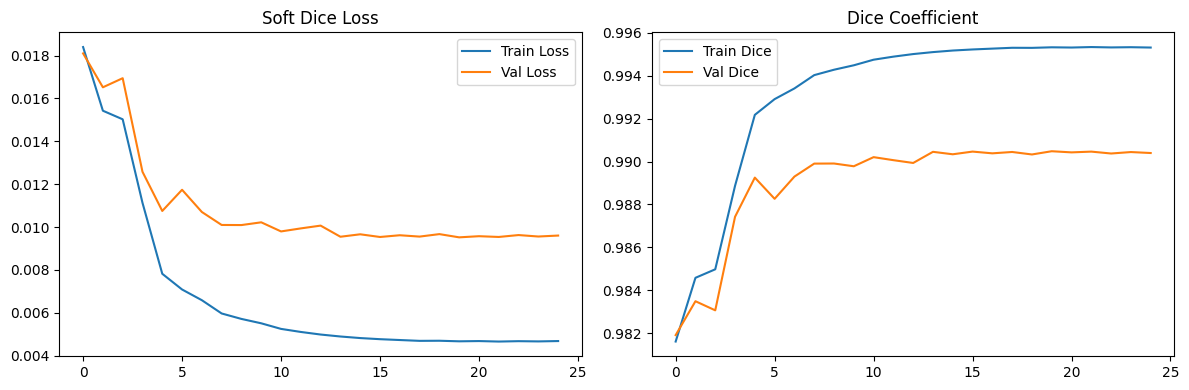

In [14]:
# Generate training history plots to visualize training and validation loss, and Dice coefficient over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Soft Dice Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient')
plt.legend()
plt.tight_layout()
plt.show()

# ***5. Prediction and Visualization***

In [22]:
# Predict and visualize segmentations for test samples
def predict_segmentation(case, zip_path, slice_to_plot=73):
    """
    Predict segmentation for a specific patient and slice.

    Args:
        case: Patient ID (e.g., '001').
        zip_path: Path to ZIP file with H5 image data.
        slice_to_plot: Slice index to process (0-based, relative to VOLUME_SLICES).

    Returns:
        tuple: FLAIR image, T1ce image, predicted segmentation, and ground truth mask.
    """
    # Prepare input array for prediction
    X = np.empty((1, IMG_HEIGHT, IMG_WIDTH, 2))

    # Load FLAIR and T1ce images for the specified slice
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        h5_file = f"{H5_FILES_PREFIX}{case}_slice_{slice_to_plot + VOLUME_START_AT}{H5_FILES_SUFFIX}"
        if h5_file in zip_ref.namelist():
            with zip_ref.open(h5_file) as f:
                with h5py.File(BytesIO(f.read()), 'r') as hf:
                    img = hf['image'][:]
            img_slice = img[:, :, [MODALITY_INDICES["FLAIR"], MODALITY_INDICES["T1ce"]]]
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + 1e-8)
            img_slice = cv2.resize(img_slice, (IMG_HEIGHT, IMG_WIDTH))
            X[0, :, :, :] = img_slice
            flair = img_slice[:, :, 0]
            t1ce = img_slice[:, :, 1]

    # Predict segmentation
    X = X / np.max(X)
    predicted_seg = model.predict(X, verbose=1)

    # Load ground truth mask
    with zipfile.ZipFile(NIFTI_ZIP_PATH, 'r') as nifti_zip_ref:
        nifti_file = f"369Seg_Masks_nii/BraTS20_Training_{int(case):03d}_seg.nii"
        with nifti_zip_ref.open(nifti_file) as f:
            gt = nib.Nifti1Image.from_bytes(f.read()).get_fdata().astype(np.uint8)

    gt_slice = gt[:, :, slice_to_plot + VOLUME_START_AT]
    gt_slice[gt_slice == 4] = 3  # Map label 4 to 3
    gt_slice = cv2.resize(gt_slice, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)

    return flair, t1ce, predicted_seg[0], gt_slice

# Visualize predictions with multi-class segmentation masks
def show_predicted_segmentations(case, slice_to_plot=73):
    """
    Visualize FLAIR, T1ce, ground truth mask (multi-class), and predicted mask (multi-class) in a 1x4 row,
    with a color legend integrated below, and softer mask edges.

    Args:
        case: Patient ID (e.g., '001').
        slice_to_plot: Slice index to visualize (0-based, relative to VOLUME_SLICES).
    """
    # Get data for visualization
    flair, t1ce, predicted_seg, gt_slice = predict_segmentation(case, ZIP_PATH, slice_to_plot)

    # Convert predicted segmentation to class labels
    predicted_mask = np.argmax(predicted_seg, axis=-1)

    # Define colormaps for multi-class visualization
    colors = ['black', 'green', 'yellow', 'red']  # Background, Non-enhancing, Edema, Enhancing
    cmap = ListedColormap(colors)
    bounds = [0, 1, 2, 3, 4]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    # Create figure with 1x4 row layout
    print(f"Patient number: BraTS20_Training_{case}")
    fig, axarr = plt.subplots(1, 4, figsize=(30, 8))

    # Plot FLAIR image
    axarr[0].imshow(flair, cmap="gray")
    axarr[0].set_title('FLAIR Image', fontsize=14, pad=10)
    axarr[0].axis('off')

    # Plot T1ce image
    axarr[1].imshow(t1ce, cmap="gray")
    axarr[1].set_title('T1ce Image', fontsize=14, pad=10)
    axarr[1].axis('off')

    # Plot ground truth mask with multi-class coloring and softer edges
    axarr[2].imshow(t1ce, cmap="gray")
    axarr[2].imshow(gt_slice, cmap=cmap, norm=norm, interpolation='bilinear', alpha=0.7)
    axarr[2].set_title('Ground Truth Mask on T1ce', fontsize=14, pad=10)
    axarr[2].axis('off')

    # Plot predicted mask overlaid on T1ce with multi-class coloring and softer edges
    axarr[3].imshow(t1ce, cmap="gray")
    axarr[3].imshow(predicted_mask, cmap=cmap, norm=norm, interpolation='bilinear', alpha=0.7)
    axarr[3].set_title('Predicted Mask on T1ce', fontsize=14, pad=10)
    axarr[3].axis('off')

    # Add color legend integrated below the row
    legend_patches = [
        plt.plot([], [], marker="s", ls="", color='green', label='Non-enhancing Tumor (Class 1)')[0],
        plt.plot([], [], marker="s", ls="", color='yellow', label='Edema (Class 2)')[0],
        plt.plot([], [], marker="s", ls="", color='red', label='Enhancing Tumor (Class 3)')[0]
    ]
    fig.legend(handles=legend_patches, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1),
               fontsize=12, frameon=False, title='Class Legend', title_fontsize=14)

    plt.tight_layout(pad=2.0)
    plt.show()

# Perform predictions for 5 random test samples at the 95th slice (index 73 after VOLUME_START_AT)
print("\nPredicting and Visualizing Segmentations for 5 Test Samples (95th Slice)...")
random_samples = random.sample(test_ids, 5)
for case in random_samples:
    show_predicted_segmentations(case, slice_to_plot=73)  # 95 - 22 = 73

# Clean up memory
tf.keras.backend.clear_session()
gc.collect()

Output hidden; open in https://colab.research.google.com to view.